<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S7/ERAV2%20S7%20Step3-Himank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

Now that our model is not over fitting we shift our focus towards improving accuracy.

Examinig data tells us that certain classes needs to be fixed by rotation, hence as part of data augmentation we can experiment with different rotation degree.

We will also add a LR scheduler to see how we can further optimize our LR.

- Add rotation, we guess that 5-7 degrees should be sufficient
- Add LR Scheduler

Results:
- Parameters: 7,416
- Best Training Accuracy: 99.03
- Best Test Accuracy: 99.44


Analysis:
- Model is not over-fitting now
- Target Accuracy acheived
- Using scheduler for LR worked
- Adding rotation of (-7.0,7.0) decreased our model's accuracy. Rotation of (-3.0,3.0) increased our accuracy but not significantly. (-5.0,5.0) Rotation works the best.
- Further experiments to reduce parameters can be done.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Net3

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 53539552.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63957599.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32190143.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3861854.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


torch.Size([64, 1, 28, 28])
torch.Size([64])


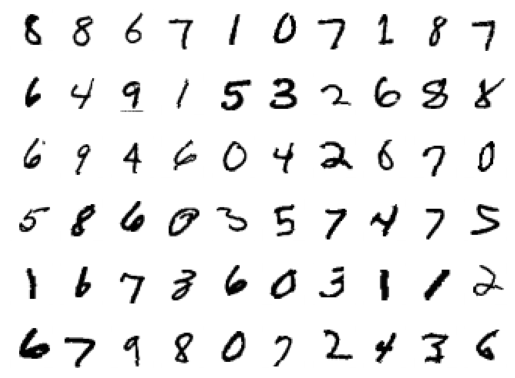

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.16867178678512573 Batch_id=937 Accuracy=90.21: 100%|██████████| 938/938 [01:11<00:00, 13.09it/s]



Test set: Average loss: 0.0604, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.12204600870609283 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [01:10<00:00, 13.28it/s]



Test set: Average loss: 0.0412, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.004185231402516365 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [01:10<00:00, 13.35it/s]



Test set: Average loss: 0.0331, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.03784327581524849 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [01:09<00:00, 13.41it/s]



Test set: Average loss: 0.0268, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.13578347861766815 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [01:08<00:00, 13.75it/s]



Test set: Average loss: 0.0289, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.040967345237731934 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [01:09<00:00, 13.53it/s]



Test set: Average loss: 0.0281, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.13332603871822357 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.00754224369302392 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [01:08<00:00, 13.62it/s]



Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.020315630361437798 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:08<00:00, 13.60it/s]



Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.0025257060769945383 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [01:08<00:00, 13.60it/s]



Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.05135779827833176 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:08<00:00, 13.66it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.012681808322668076 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [01:08<00:00, 13.70it/s]



Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.12154170870780945 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:10<00:00, 13.23it/s]



Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.005352389998733997 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:10<00:00, 13.32it/s]



Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.02558167465031147 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:11<00:00, 13.14it/s]



Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

